<a href="https://colab.research.google.com/github/fadelramli/Tugas-MachineLearning/blob/main/Week9_Model_Selection%2C_Underfitting%2C_and_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [2]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[1.7723365 ],
        [0.41375464]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[1.0000000e+00, 1.7723365e+00, 1.5705882e+00, 9.2787027e-01,
         4.1112459e-01, 1.4573021e-01, 4.3047164e-02, 1.0899151e-02,
         2.4146202e-03, 4.7550219e-04, 8.4274987e-05, 1.3578512e-05,
         2.0054742e-06, 2.7341349e-07, 3.4612906e-08, 4.0897143e-09,
         4.5302187e-10, 4.7229835e-11, 4.6503977e-12, 4.3379311e-13],
        [1.0000000e+00, 4.1375464e-01, 8.5596450e-02, 1.1805309e-02,
         1.2211252e-03, 1.0104925e-04, 6.9682656e-06, 4.1187886e-07,
         2.1302098e-08, 9.7931574e-10, 4.0519643e-11, 1.5241082e-12,
         5.2550568e-14, 1.6725415e-15, 4.9430130e-17, 1.3634630e-18,
         3.5258696e-20, 8.5814405e-22, 1.9725614e-23, 4.2955601e-25]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.9997754, 5.387907 ], dtype=float32)>)

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.9984603  1.2283199 -3.411097   5.5652547]]


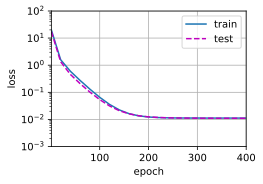

In [7]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.7974207 4.182775 ]]


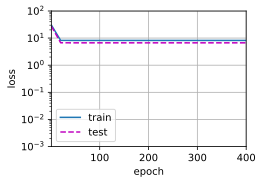

In [8]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.975783    1.3251839  -3.3362432   5.138375   -0.29085016  1.1502262
   0.56468135 -0.02466589  0.5162398  -0.15696532 -0.24338204 -0.15707025
   0.4729148  -0.15273884 -0.3202384  -0.49603072 -0.36871603 -0.08678758
  -0.13202283  0.125745  ]]


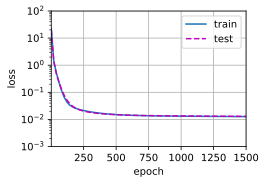

In [9]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)